# BERT Fine-Tuning для задачи классификации новостей с сильными ветрами на интенсивность по шкале Бофорта

Основой для этого ноутбука было [приложение](https://peerj.com/articles/cs-1859/#supplemental-information) к статье 

`Malik, Muhammad Shahid Iqbal, et al. "Categorization of tweets for damages: infrastructure and human damage assessment using fine-tuned BERT model." PeerJ Computer Science 10 (2024): e1859.`

P.S. И сама статья

### Код запускался в `kaggle` на `P100-PCIE-16GB`

In [5]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#% matplotlib inline
import seaborn as sns
import time
import re
import datetime
import random
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import Dataset
from transformers import BertForSequenceClassification, BertConfig
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

2025-05-07 04:47:21.681491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746593241.859212      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746593241.912534      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Импортируем данные с ветрами

In [13]:
wind = pd.read_excel('/kaggle/input/heavy-winds/wind_bof_dis.xlsx')
wind_work = wind[['Text', 'News_type', 'Location_ATD4', 'Phenomena', 'Класс']]
wind_work.head()

,Text,News_type,Location_ATD4,Phenomena,Класс
0,🔹В Ангарском округе устраняют последствия непо...,событие,Иркутская область,сильные ветры,9
1,Пострадавшие от ЧС приморцы могут подать заявл...,прогноз/предупреждение,Приморский край,наводнение,0
2,❗ВНИМАНИЕ ❗ На Центральную Россию надвигается...,прогноз/предупреждение,Орловская область,сильные ветры,10
3,Рязанцев предупреждают об ухудшении погодных у...,прогноз/предупреждение,Рязанская область,гололед; мороз; КНПЯ,8
4,#Югра #БерезовскийРайон В лесах Югры завершилс...,событие,Ямало-Ненецкий автономный округ,ландшафтные пожары,0


In [7]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
def normalise_text(text):
    text = text.lower()

    # сурово регулярками выкидываем мусорные символы
    # text = re.sub('[^а-яa-z ]', '', text)
    text = re.sub(r'\d+', '', text)
    stops_regex = r'\b(?:' + '|'.join(map(re.escape, stops)) + r')\b'
    text = re.sub(stops_regex, '', text)

    # Удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    return text

stops = ['м/сек', 'м/с', 'м / с','м / сек','метров в секунду',
         'метра в секунду', 'метр в секунду',
         'мм', 'c', 'лицензия', 'creative',
         'commons', 'attribution']

wind_work['text_clean'] = wind_work.Text.apply(normalise_text)

wind_work.head()

/tmp/ipykernel_31/4042448939.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_work['text_clean'] = wind_work.Text.apply(normalise_text)


,Text,News_type,Location_ATD4,Phenomena,Класс,text_clean
0,🔹В Ангарском округе устраняют последствия непо...,событие,Иркутская область,сильные ветры,9,🔹в ангарском округе устраняют последствия непо...
1,Пострадавшие от ЧС приморцы могут подать заявл...,прогноз/предупреждение,Приморский край,наводнение,0,пострадавшие от чс приморцы могут подать заявл...
2,❗ВНИМАНИЕ ❗ На Центральную Россию надвигается...,прогноз/предупреждение,Орловская область,сильные ветры,10,❗внимание ❗ на центральную россию надвигается ...
3,Рязанцев предупреждают об ухудшении погодных у...,прогноз/предупреждение,Рязанская область,гололед; мороз; КНПЯ,8,рязанцев предупреждают об ухудшении погодных у...
4,#Югра #БерезовскийРайон В лесах Югры завершилс...,событие,Ямало-Ненецкий автономный округ,ландшафтные пожары,0,#югра #березовскийрайон в лесах югры завершилс...


In [14]:
wind_work['text_clean'] = wind_work['Text']

/tmp/ipykernel_31/1751635804.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_work['text_clean'] = wind_work['Text']


In [43]:
# custom_stop_words = set(['м', 'с', 'мм', 'c', 'км', 'метр',
#                      'секунда', 'лицензия', 'creative', 'commons', 'attribution'])
# stops_ru = set(stopwords.words('russian'))
# stops = list(custom_stop_words|stops_ru)

In [15]:
# Если классификация на 8 классов, то надо запускать эту ячейку
wind_work = wind_work[wind_work['Класс']>4]
wind_work['Класс'] = wind_work['Класс']-5
df, df_test = train_test_split(wind_work, test_size=0.2, random_state=42)

In [9]:
# # Если классификация на 5 классов, то надо запускать эту ячейку
# def to_change_classes(value):
#     if value<=7:
#         return 0
#     elif value == 8:
#         return 1
#     elif value == 9:
#         return 2
#     elif value == 10:
#         return 3
#     else:
#         return 4

# wind_work = wind_work[wind_work['Класс']>4]
# wind_work['Класс'] = wind_work['Класс'].apply(to_change_classes)

In [ ]:
df, df_test = train_test_split(wind_work, test_size=0.2, random_state=42)

In [16]:
df['Класс'].value_counts()

Класс
3    2058
5    1511
4    1483
2     842
6     350
7     220
1     147
0     123
Name: count, dtype: int64

In [17]:
sentences = df.text_clean.values
labels = df.Класс.values

### Токенизация `bert-base-uncased`

In [18]:
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Let's apply the tokenizer to one sentence just to see the output.


In [19]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  ШТОРМОВОЕ ПРЕДУПРЕЖДЕНИЕ! МКУ «УГОЧС Г. Новоалтайска» информирует В Алтайском крае во второй половине ночи и днем 13 декабря 2022 ожидается усиление ветра местами 17-22 м/с, по юго-востоку порывы 25-27 м/с, снег, местами сильный, метели. На дорогах снежные заносы. 14-16 декабря установление морозной погоды. При возникновении происшествий и чрезвычайных ситуаций немедленно информировать экстренные службы города по телефонам: 101, 112, тел. 8-(385)-32-4-33-55, 8-(385)-32-4-33-44. Будьте осторожны!
Tokenized:  ['ш', '##т', '##о', '##р', '##м', '##ов', '##о', '##е', 'п', '##р', '##е', '##д', '##у', '##п', '##р', '##е', '##ж', '##д', '##е', '##н', '##и', '##е', '!', 'м', '##к', '##у', '«', 'у', '##г', '##о', '##ч', '##с', 'г', '.', 'н', '##ов', '##о', '##а', '##л', '##т', '##а', '##и', '##с', '##ка', '»', 'и', '##н', '##ф', '##о', '##р', '##м', '##и', '##р', '##у', '##е', '##т', 'в', 'а', '##л', '##т', '##а', '##и', '##с', '##к', '##о', '##м', 'к', '##р', '##а', '##е', 'в', '##о

In [19]:
maxx=0
for sent in sentences:
    if len(tokenizer.tokenize(sent))>maxx:
        maxx=len(tokenizer.tokenize(sent))
print(maxx)

10933


In [33]:
max_len = 512

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True,
                                 max_length=512, truncation=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  512


In [20]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt'     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  ШТОРМОВОЕ ПРЕДУПРЕЖДЕНИЕ! МКУ «УГОЧС Г. Новоалтайска» информирует В Алтайском крае во второй половине ночи и днем 13 декабря 2022 ожидается усиление ветра местами 17-22 м/с, по юго-востоку порывы 25-27 м/с, снег, местами сильный, метели. На дорогах снежные заносы. 14-16 декабря установление морозной погоды. При возникновении происшествий и чрезвычайных ситуаций немедленно информировать экстренные службы города по телефонам: 101, 112, тел. 8-(385)-32-4-33-55, 8-(385)-32-4-33-44. Будьте осторожны!
Token IDs: tensor([  101,  1203, 22919, 14150, 16856, 29745, 19259, 14150, 15290,  1194,
        16856, 15290, 29742, 29748, 29746, 16856, 15290, 29743, 29742, 15290,
        18947, 10325, 15290,   999,  1191, 23925, 29748,  1077,  1198, 29741,
        14150, 29752, 29747,  1183,  1012,  1192, 19259, 14150, 10260, 29436,
        22919, 10260, 10325, 29747, 28598,  1090,  1188, 18947, 29749, 14150,
        16856, 29745, 10325, 16856, 29748, 15290, 22919,  1182,  1180, 29436,
        2

### Training & Validation Split

In [21]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,060 training samples
  674 validation samples


In [22]:
# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### Classification Model. При классификации на 5 классов, `num_labels = 5`, на 8 - `num_labels = 8`

In [23]:
# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 8, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [18]:
# # Load BertForSequenceClassification, the pretrained BERT model with a single
# # linear classification layer on top.
# model = BertForSequenceClassification.from_pretrained(
#     "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
#     num_labels = 5, # The number of output labels--2 for binary classification.
#                     # You can increase this for multi-class tasks.
#     output_attentions = False, # Whether the model returns attentions weights.
#     output_hidden_states = False, # Whether the model returns all hidden-states.
# )

# # Tell pytorch to run this model on the GPU.
# model.cuda()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [18]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

### Optimizer & Learning Rate Scheduler

In [24]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [25]:
len(train_dataloader) * 4

760

In [26]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 76, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### Training Loop

Define a helper function for calculating accuracy.

In [27]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`


In [28]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

### Тренировка модели для 5-ти классов

### 5 классов

In [26]:
# # This training code is based on the `run_glue.py` script here:
# # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# # Set the seed value all over the place to make this reproducible.
# seed_val = 42

# random.seed(seed_val)
# np.random.seed(seed_val)
# torch.manual_seed(seed_val)
# torch.cuda.manual_seed_all(seed_val)

# # We'll store a number of quantities such as training and validation loss,
# # validation accuracy, and timings.
# training_stats = []

# # Measure the total training time for the whole run.
# total_t0 = time.time()

# # For each epoch...
# for epoch_i in range(0, epochs):

#     # ========================================
#     #               Training
#     # ========================================

#     # Perform one full pass over the training set.

#     print("")
#     print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
#     print('Training...')

#     # Measure how long the training epoch takes.
#     t0 = time.time()

#     # Reset the total loss for this epoch.
#     total_train_loss = 0

#     # Put the model into training mode. Don't be mislead--the call to
#     # `train` just changes the *mode*, it doesn't *perform* the training.
#     # `dropout` and `batchnorm` layers behave differently during training
#     # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
#     model.train()

#     # For each batch of training data...
#     for step, batch in enumerate(train_dataloader):

#         # Progress update every 40 batches.
#         if step % 40 == 0 and not step == 0:
#             # Calculate elapsed time in minutes.
#             elapsed = format_time(time.time() - t0)

#             # Report progress.
#             print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

#         # Unpack this training batch from our dataloader.
#         #
#         # As we unpack the batch, we'll also copy each tensor to the GPU using the
#         # `to` method.
#         #
#         # `batch` contains three pytorch tensors:
#         #   [0]: input ids
#         #   [1]: attention masks
#         #   [2]: labels
#         b_input_ids = batch[0].to(device)
#         b_input_mask = batch[1].to(device)
#         b_labels = batch[2].to(device)

#         # Always clear any previously calculated gradients before performing a
#         # backward pass. PyTorch doesn't do this automatically because
#         # accumulating the gradients is "convenient while training RNNs".
#         # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
#         model.zero_grad()

#         # Perform a forward pass (evaluate the model on this training batch).
#         # In PyTorch, calling `model` will in turn call the model's `forward`
#         # function and pass down the arguments. The `forward` function is
#         # documented here:
#         # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
#         # The results are returned in a results object, documented here:
#         # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
#         # Specifically, we'll get the loss (because we provided labels) and the
#         # "logits"--the model outputs prior to activation.
#         result = model(b_input_ids,
#                        token_type_ids=None,
#                        attention_mask=b_input_mask,
#                        labels=b_labels,
#                        return_dict=True)

#         loss = result.loss
#         logits = result.logits

#         # Accumulate the training loss over all of the batches so that we can
#         # calculate the average loss at the end. `loss` is a Tensor containing a
#         # single value; the `.item()` function just returns the Python value
#         # from the tensor.
#         total_train_loss += loss.item()

#         # Perform a backward pass to calculate the gradients.
#         loss.backward()

#         # Clip the norm of the gradients to 1.0.
#         # This is to help prevent the "exploding gradients" problem.
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

#         # Update parameters and take a step using the computed gradient.
#         # The optimizer dictates the "update rule"--how the parameters are
#         # modified based on their gradients, the learning rate, etc.
#         optimizer.step()

#         # Update the learning rate.
#         scheduler.step()

#     # Calculate the average loss over all of the batches.
#     avg_train_loss = total_train_loss / len(train_dataloader)

#     # Measure how long this epoch took.
#     training_time = format_time(time.time() - t0)

#     print("")
#     print("  Average training loss: {0:.2f}".format(avg_train_loss))
#     print("  Training epcoh took: {:}".format(training_time))

#     # ========================================
#     #               Validation
#     # ========================================
#     # After the completion of each training epoch, measure our performance on
#     # our validation set.

#     print("")
#     print("Running Validation...")

#     t0 = time.time()

#     # Put the model in evaluation mode--the dropout layers behave differently
#     # during evaluation.
#     model.eval()

#     # Tracking variables
#     total_eval_accuracy = 0
#     total_eval_loss = 0
#     nb_eval_steps = 0

#     # Evaluate data for one epoch
#     for batch in validation_dataloader:

#         # Unpack this training batch from our dataloader.
#         #
#         # As we unpack the batch, we'll also copy each tensor to the GPU using
#         # the `to` method.
#         #
#         # `batch` contains three pytorch tensors:
#         #   [0]: input ids
#         #   [1]: attention masks
#         #   [2]: labels
#         b_input_ids = batch[0].to(device)
#         b_input_mask = batch[1].to(device)
#         b_labels = batch[2].to(device)

#         # Tell pytorch not to bother with constructing the compute graph during
#         # the forward pass, since this is only needed for backprop (training).
#         with torch.no_grad():

#             # Forward pass, calculate logit predictions.
#             # token_type_ids is the same as the "segment ids", which
#             # differentiates sentence 1 and 2 in 2-sentence tasks.
#             result = model(b_input_ids,
#                            token_type_ids=None,
#                            attention_mask=b_input_mask,
#                            labels=b_labels,
#                            return_dict=True)

#         # Get the loss and "logits" output by the model. The "logits" are the
#         # output values prior to applying an activation function like the
#         # softmax.
#         loss = result.loss
#         logits = result.logits

#         # Accumulate the validation loss.
#         total_eval_loss += loss.item()

#         # Move logits and labels to CPU
#         logits = logits.detach().cpu().numpy()
#         label_ids = b_labels.to('cpu').numpy()

#         # Calculate the accuracy for this batch of test sentences, and
#         # accumulate it over all batches.
#         total_eval_accuracy += flat_accuracy(logits, label_ids)


#     # Report the final accuracy for this validation run.
#     avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
#     print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

#     # Calculate the average loss over all of the batches.
#     avg_val_loss = total_eval_loss / len(validation_dataloader)

#     # Measure how long the validation run took.
#     validation_time = format_time(time.time() - t0)

#     print("  Validation Loss: {0:.2f}".format(avg_val_loss))
#     print("  Validation took: {:}".format(validation_time))

#     # Record all statistics from this epoch.
#     training_stats.append(
#         {
#             'epoch': epoch_i + 1,
#             'Training Loss': avg_train_loss,
#             'Valid. Loss': avg_val_loss,
#             'Valid. Accur.': avg_val_accuracy,
#             'Training Time': training_time,
#             'Validation Time': validation_time
#         }
#     )

# print("")
# print("Training complete!")

# print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    190.    Elapsed: 0:01:24.
  Batch    80  of    190.    Elapsed: 0:02:49.
  Batch   120  of    190.    Elapsed: 0:04:14.
  Batch   160  of    190.    Elapsed: 0:05:39.

  Average training loss: 1.56
  Training epcoh took: 0:06:43

Running Validation...
  Accuracy: 0.28
  Validation Loss: 1.52
  Validation took: 0:00:11

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    190.    Elapsed: 0:01:23.
  Batch    80  of    190.    Elapsed: 0:02:49.
  Batch   120  of    190.    Elapsed: 0:04:14.
  Batch   160  of    190.    Elapsed: 0:05:39.

  Average training loss: 0.39
  Training epcoh took: 0:06:42

Running Validation...
  Accuracy: 0.95
  Validation Loss: 0.15
  Validation took: 0:00:11

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    190.    Elapsed: 0:01:24.
  Batch    80  of    190.    Elapsed: 0:02:49.
  Batch   120  of    190.    Elapsed: 0:04:14.
  Batch   160  of    190.    Elapsed: 0:05:39.



### 8 классов

In [29]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward`
        # function and pass down the arguments. The `forward` function is
        # documented here:
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the
        # output values prior to applying an activation function like the
        # softmax.
        loss = result.loss
        logits = result.logits

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    190.    Elapsed: 0:01:23.
  Batch    80  of    190.    Elapsed: 0:02:47.
  Batch   120  of    190.    Elapsed: 0:04:11.
  Batch   160  of    190.    Elapsed: 0:05:35.

  Average training loss: 1.77
  Training epcoh took: 0:06:38

Running Validation...
  Accuracy: 0.30
  Validation Loss: 1.76
  Validation took: 0:00:11

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    190.    Elapsed: 0:01:22.
  Batch    80  of    190.    Elapsed: 0:02:46.
  Batch   120  of    190.    Elapsed: 0:04:10.
  Batch   160  of    190.    Elapsed: 0:05:34.

  Average training loss: 1.20
  Training epcoh took: 0:06:37

Running Validation...
  Accuracy: 0.92
  Validation Loss: 0.33
  Validation took: 0:00:11

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    190.    Elapsed: 0:01:23.
  Batch    80  of    190.    Elapsed: 0:02:47.
  Batch   120  of    190.    Elapsed: 0:04:11.
  Batch   160  of    190.    Elapsed: 0:05:35.



In [30]:
# Устанавливаем формат отображения для чисел с плавающей запятой
pd.set_option('display.float_format', '{:.2f}'.format)

# Создаем DataFrame из наших статистик обучения
df_stats = pd.DataFrame(data=training_stats)

# Используем 'epoch' в качестве индекса строк
df_stats = df_stats.set_index('epoch')

# Отображаем таблицу
df_stats


,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.77,1.76,0.30,0:06:38,0:00:11
2,1.20,0.33,0.92,0:06:37,0:00:11
3,0.24,0.19,0.94,0:06:38,0:00:11
4,0.17,0.19,0.95,0:06:38,0:00:11


### Лоссы на train и val для 5 классов

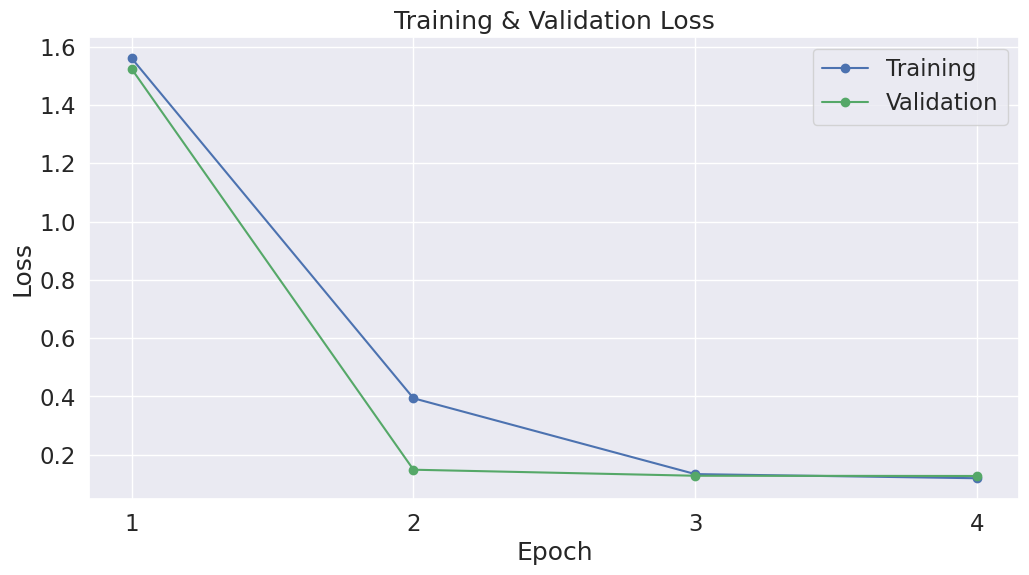

In [28]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

### Лоссы на train и val для 8 классов

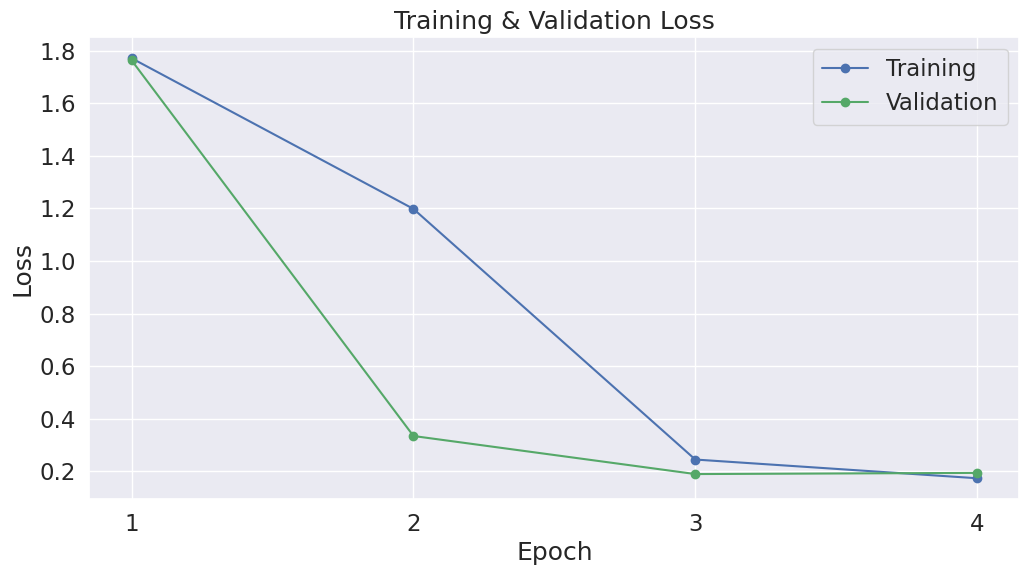

In [31]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [32]:
# # Сохранение модели
# model_save_path = 'kaggle/working/bert_model_velocity_8c'
# model.save_pretrained(model_save_path)
# tokenizer.save_pretrained(model_save_path)  # Сохраните токенизатор, если необходимо
# print(f"Модель BERT сохранена по пути: {model_save_path}")


Модель BERT сохранена по пути: kaggle/working/bert_model_velocity_8c


### Посмотрим, как модель справляется с test

In [33]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))

# Create sentence and label lists
sentences = df_test.text_clean.values
labels = df_test.Класс.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
# max_len = 512

# # For every sentence...
# for sent in sentences:

#     # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
#     input_ids = tokenizer.encode(sent, add_special_tokens=True,
#                                  max_length=512, truncation=True)

#     # Update the maximum sentence length.
#     max_len = max(max_len, len(input_ids))

# print('Max sentence length: ', max_len)

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 1,684



/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [34]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,684 test sentences...
    DONE.


In [35]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [36]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.941


In [37]:

from sklearn import metrics
confusion_matrix= metrics.confusion_matrix(flat_true_labels, flat_predictions)
print(confusion_matrix)


# TN   FP
# FN   TP

[[ 28   0   0   1   0   0   0   0]
 [  0  29   2   0   1   2   0   0]
 [  2   1 181   1   0   8   0   1]
 [  0   1   2 499   0  22   0   0]
 [  0   0   0   2 337   4   0   0]
 [  0   0   0   5   2 394   1   0]
 [  0   0   0   1   1   4  91   0]
 [  1   0   0   4   1   5   3  47]]


### Метрики для классификации на 5 классов

In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Вычисляем и выводим метрики
print('Accuracy Score: %.3f' % accuracy_score(flat_true_labels, flat_predictions))
print('Precision Score (macro): %.3f' % precision_score(flat_true_labels, flat_predictions, average='macro'))
print('Recall Score (macro): %.3f' % recall_score(flat_true_labels, flat_predictions, average='macro'))
print('F1 Score (macro): %.3f' % f1_score(flat_true_labels, flat_predictions, average='macro'))

# Если вам нужна микро-метрика, вы можете использовать:
print('Precision Score (micro): %.3f' % precision_score(flat_true_labels, flat_predictions, average='micro'))
print('Recall Score (micro): %.3f' % recall_score(flat_true_labels, flat_predictions, average='micro'))
print('F1 Score (micro): %.3f' % f1_score(flat_true_labels, flat_predictions, average='micro'))


Accuracy Score: 0.956
Precision Score (macro): 0.953
Recall Score (macro): 0.951
F1 Score (macro): 0.951
Precision Score (micro): 0.956
Recall Score (micro): 0.956
F1 Score (micro): 0.956


### Метрики для классификации на 8 классов

In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Вычисляем и выводим метрики
print('Accuracy Score: %.3f' % accuracy_score(flat_true_labels, flat_predictions))
print('Precision Score (macro): %.3f' % precision_score(flat_true_labels, flat_predictions, average='macro'))
print('Recall Score (macro): %.3f' % recall_score(flat_true_labels, flat_predictions, average='macro'))
print('F1 Score (macro): %.3f' % f1_score(flat_true_labels, flat_predictions, average='macro'))

# Если вам нужна микро-метрика, вы можете использовать:
print('Precision Score (micro): %.3f' % precision_score(flat_true_labels, flat_predictions, average='micro'))
print('Recall Score (micro): %.3f' % recall_score(flat_true_labels, flat_predictions, average='micro'))
print('F1 Score (micro): %.3f' % f1_score(flat_true_labels, flat_predictions, average='micro'))


Accuracy Score: 0.954
Precision Score (macro): 0.951
Recall Score (macro): 0.922
F1 Score (macro): 0.934
Precision Score (micro): 0.954
Recall Score (micro): 0.954
F1 Score (micro): 0.954


In [43]:
wind[wind['Класс']==0]

,Unnamed: 0,_ID,Event_ID,News_link,Text,News_length,Количество,News_source,News_type,Location_ATD4,...,fix_Date_start,fix_Date_end,Date_period,Date_post,Максимальное число,Класс,Location_clean,loc_num,result,conf
1,1,e447d513-4b2e-45c8-87ad-d61f71a30b86,NaN,https://vk.com/wall-201160589_12524,Пострадавшие от ЧС приморцы могут подать заявл...,2469,1,ВКонтакте,прогноз/предупреждение,Приморский край,...,2023-12-15,2024-06-30,198.00,NaN,NaN,0,приморский,[2],ОПЯ,99.09
4,4,847eee10-90e7-4c6d-8ed5-ea1f14740fa5,NaN,https://vk.com/wall-31196850_2881,#Югра #БерезовскийРайон В лесах Югры завершилс...,2843,1,ВКонтакте,событие,Ямало-Ненецкий автономный округ,...,2018-04-23,2018-10-15,175.00,NaN,NaN,0,ямалоненецкий,[20],ОПЯ,99.99
6,6,92a95981-2134-494a-8947-bd1726668347,осадк_2021-01_92a95981,https://vk.com/wall-152984073_27533,Администрация района не только поможет заменит...,1216,1,ВКонтакте,событие,Мурманская область,...,2021-09-01,2021-12-31,121.00,2021-12-20 13:17,NaN,0,мурманская,[32],ОПЯ,99.97
8,8,0ffbd044-2628-4ceb-8904-739242c2c09c,ветер_2020-06_c5cdf5d8,https://vk.com/wall-111648778_11430,14 июля в поселке Болонь ураганом были поврежд...,312,1,ВКонтакте,событие,Рязанская область,...,2020-07-01,2020-10-15,106.00,2020-11-09 16:44,NaN,0,рязанская,[62],ОПЯ,99.99
9,9,0c590f9d-7fc6-4442-9180-b3ea403087ed,NaN,https://vk.com/wall-184003583_39837,В Евпатории высадят более 2700 деревьев на мес...,1490,1,ВКонтакте,событие,Республика Крым,...,2023-09-01,2023-11-30,90.00,NaN,NaN,0,крым,[5],ОПЯ,99.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12725,12725,48ecf4ec-021a-4e48-b297-a886dffd3e6d,кнпя_2023-12_f2101aee,https://vk.com/wall-118907081_65704,В Салехарде усиленными темпами убирают последс...,766,1,ВКонтакте,событие,Ямало-Ненецкий автономный округ,...,2023-12-31,NaT,NaN,2023-12-31 12:12,NaN,0,ямалоненецкий,[20],ОПЯ,99.99
12728,12728,2039d84b-b135-4fd2-b194-e66b8343b39f,кнпя_2018-03_5b833a84,https://vk.com/wall-55811535_75423,Дорожники работают над устранением последствий...,3407,1,ВКонтакте,событие,Ямало-Ненецкий автономный округ,...,2018-03-06,NaT,NaN,2018-03-07 9:07,NaN,0,ямалоненецкий,[20],ОПЯ,99.98
12729,12729,ebdb92bd-8d00-4096-8028-61bd64f9c58b,кнпя_2018-03_ebdb92bd,https://vk.com/wall-55811535_75298,"Дорожники расчистили зимники после метели, аэр...",3970,1,ВКонтакте,событие,Ямало-Ненецкий автономный округ,...,2018-03-01,NaT,NaN,2018-03-02 8:36,NaN,0,ямалоненецкий,[20],ОПЯ,99.94
12730,12730,1a6aec01-d187-4fd4-976c-39e303cb1c2a,ветер_2019-07_a8f962ef,https://vk.com/wall-170589660_913,В Ханымее восстанавливают жилье после июльског...,1380,1,ВКонтакте,событие,Ямало-Ненецкий автономный округ,...,2019-07-04,NaT,NaN,2019-08-01 10:03,NaN,0,ямалоненецкий,[20],ОПЯ,99.88


In [45]:
df_test_test = wind[wind['Класс']==0]

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df_test_test.shape[0]))

# Create sentence and label lists
sentences = df_test_test.Text.values
labels = df_test_test.Класс.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
# max_len = 512

# # For every sentence...
# for sent in sentences:

#     # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
#     input_ids = tokenizer.encode(sent, add_special_tokens=True,
#                                  max_length=512, truncation=True)

#     # Update the maximum sentence length.
#     max_len = max(max_len, len(input_ids))

# print('Max sentence length: ', max_len)

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 4,272



/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [46]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 4,272 test sentences...
    DONE.


In [47]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
len(flat_predictions)

4272

In [48]:
t = df_test_test
t['Класс'] = flat_predictions
t['Класс'].head()

/tmp/ipykernel_31/1295197112.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['Класс'] = flat_predictions


1    5
4    5
6    5
8    2
9    5
Name: Класс, dtype: int64

In [49]:
flat_predictions[:5]

array([5, 5, 5, 2, 5])

In [50]:
# t.to_excel('/kaggle/working/predicts_intensity_BERT_velocity_8cl.xlsx')

### Сделаем predict на данных без размеченного класса по Бофорту

In [35]:
df_test_test = wind_work[wind_work['Класс']<=4]

# Отчет о количестве предложений
print('Number of test sentences: {:,}\n'.format(df_test_test.shape[0]))

# Создание списка предложений
sentences = df_test_test.text_clean.values

# Токенизация всех предложений и сопоставление токенов с их ID
input_ids = []
attention_masks = []

# Для каждого предложения...
for sent in sentences:
    # `encode_plus` будет:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Предложение для кодирования
                        add_special_tokens=True,   # Добавить '[CLS]' и '[SEP]'
                        max_length=512,            # Дополнить и обрезать все предложения
                        pad_to_max_length=True,
                        return_attention_mask=True, # Вернуть маску внимания
                        return_tensors='pt',       # Вернуть тензоры PyTorch
                   )

    # Добавление закодированного предложения в список
    input_ids.append(encoded_dict['input_ids'])

    # И его маска внимания
    attention_masks.append(encoded_dict['attention_mask'])

# Преобразование списков в тензоры
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Установка размера пакета
batch_size = 32

# Создание DataLoader без меток
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Теперь вы можете использовать prediction_dataloader для предсказания с помощью вашей модели


Number of test sentences: 8,418



/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [36]:
df_test_test

,Text,News_type,Location_ATD4,Phenomena,Класс,text_clean
0,🔹В Ангарском округе устраняют последствия непо...,событие,Иркутская область,сильные ветры,2,🔹в ангарском округе устраняют последствия непо...
2,❗ВНИМАНИЕ ❗ На Центральную Россию надвигается...,прогноз/предупреждение,Орловская область,сильные ветры,3,❗внимание ❗ на центральную россию надвигается ...
3,Рязанцев предупреждают об ухудшении погодных у...,прогноз/предупреждение,Рязанская область,гололед; мороз; КНПЯ,1,рязанцев предупреждают об ухудшении погодных у...
5,⚠️ Внимание! Экстренное предупреждение! ☔ П...,прогноз/предупреждение,Орловская область,сильные ветры,3,⚠️ внимание! экстренное предупреждение! ☔ по д...
7,☔В Рязани в ближайшее время ожидаются гроза и ...,прогноз/предупреждение,Рязанская область,сильные ветры,0,☔в рязани в ближайшее время ожидаются гроза и ...
...,...,...,...,...,...,...
12722,Непогода внесла коррективы в жизнь города. Вне...,событие,Ямало-Ненецкий автономный округ,сильные ветры,3,непогода внесла коррективы в жизнь города. вне...
12726,8 февраля в Салехарде из-за шквалистого ветра ...,событие,Ямало-Ненецкий автономный округ,сильные ветры,2,февраля в салехарде из-за шквалистого ветра до...
12727,Дорожные службы оперативно устраняют последств...,событие,Ямало-Ненецкий автономный округ,сильные осадки,2,дорожные службы оперативно устраняют последств...
12731,⛈По территории Пуровского района прошел грозов...,событие,Ямало-Ненецкий автономный округ,сильные ветры,0,⛈по территории пуровского района прошел грозов...
